In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import statsmodels.api as sm



from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression


# %pip install pmdarima
import pmdarima as pm

# %pip install statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX




In [2]:
Temperature = pd.read_csv("jena_climate_2009_2016.csv")
print(Temperature.head())

             Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0       1307.75      1.03        

In [3]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [4]:
TRAIN_SPLIT = 12000
tf.random.set_seed(13)

In [5]:
uni_data = Temperature['T (degC)']
uni_data.index = Temperature['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<AxesSubplot: xlabel='Date Time'>], dtype=object)

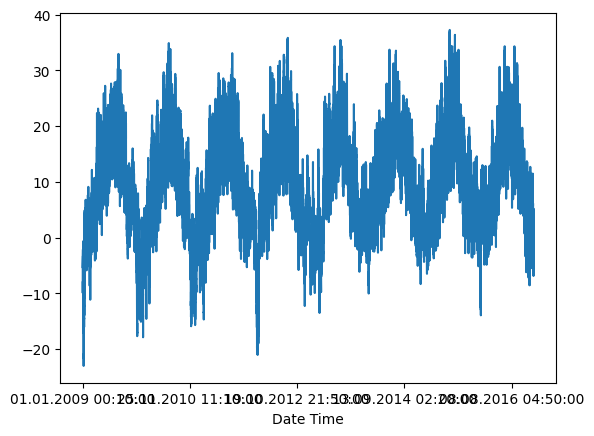

In [6]:
uni_data.plot(subplots=True)

In [7]:
# Стандартизация данных
# Нормализовать следует только данные из обучаемой выборки
uni_data = uni_data.values
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [8]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [9]:
univariate_past_history = 50
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [10]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target Tq to predict')
print (y_train_uni[0])

Single window of past history
[[-1.50692401]
 [-1.58192395]
 [-1.6011547 ]
 [-1.56269319]
 [-1.55500089]
 [-1.51269324]
 [-1.430001  ]
 [-1.430001  ]
 [-1.48577018]
 [-1.5857701 ]
 [-1.64923158]
 [-1.67230848]
 [-1.66653926]
 [-1.66269311]
 [-1.63000083]
 [-1.63000083]
 [-1.63769313]
 [-1.65884696]
 [-1.66461618]
 [-1.68384693]
 [-1.68384693]
 [-1.66846233]
 [-1.69346231]
 [-1.70500076]
 [-1.73961612]
 [-1.78961607]
 [-1.79153915]
 [-1.76269302]
 [-1.78576992]
 [-1.81653913]
 [-1.82423143]
 [-1.8261545 ]
 [-1.86846216]
 [-1.87038523]
 [-1.79346222]
 [-1.82423143]
 [-1.80884683]
 [-1.72423151]
 [-1.67807771]
 [-1.70307769]
 [-1.77807762]
 [-1.72807767]
 [-1.6396162 ]
 [-1.608847  ]
 [-1.58000087]
 [-1.56077012]
 [-1.52807784]
 [-1.52230861]
 [-1.53000091]
 [-1.51461631]]

 Target Tq to predict
-1.4934624842970925


##### Источник https://github.com/aikula/f2forecast/blob/master/Course_f2forecast.ipynb

In [11]:
# Переименование столбцов
new_names = {'T (degC)': 'temperature', 'Tpot (K)': 'temperature_potential', 'Tdew (degC)': 'dew_point',
             'VPmax (mbar)': 'saturation_vapor_pressure_max', 'VPact (mbar)': 'actual_vapor_pressure',
             'VPdef (mbar)': 'vapor_pressure_deficit', 'sh (g/kg)': 'specific_humidity', 'H2OC (mmol/mol)': 'water_vapor_concentration'}
Temperature = Temperature.rename(columns=new_names)

# Удаление пропущенных значений
Temperature = Temperature.dropna()

# Вывод первых строк набора данных
print(Temperature.head())

             Date Time  p (mbar)  temperature  temperature_potential  \
0  01.01.2009 00:10:00    996.52        -8.02                 265.40   
1  01.01.2009 00:20:00    996.57        -8.41                 265.01   
2  01.01.2009 00:30:00    996.53        -8.51                 264.91   
3  01.01.2009 00:40:00    996.51        -8.31                 265.12   
4  01.01.2009 00:50:00    996.51        -8.27                 265.15   

   dew_point  rh (%)  saturation_vapor_pressure_max  actual_vapor_pressure  \
0      -8.90    93.3                           3.33                   3.11   
1      -9.28    93.4                           3.23                   3.02   
2      -9.31    93.9                           3.21                   3.01   
3      -9.07    94.2                           3.26                   3.07   
4      -9.04    94.1                           3.27                   3.08   

   vapor_pressure_deficit  specific_humidity  water_vapor_concentration  \
0                    0.

In [12]:
# Определение признаков и целевой переменной
features = Temperature.columns[1:]
target = 'temperature'

# Разделение на обучающую и тестовую выборки
train_data, test_data, train_target, test_target = train_test_split(Temperature[features], Temperature[target], test_size=0.2, shuffle=False)

print(f'Размер обучающей выборки: {len(train_data)}')
print(f'Размер тестовой выборки: {len(test_data)}')

Размер обучающей выборки: 336440
Размер тестовой выборки: 84111


In [13]:
# # Используем метод auto_arima() для подбора оптимальных параметров модели SARIMA
# model = pm.auto_arima(train_data['temperature'].iloc[::1000], seasonal=True, m=12, suppress_warnings=True)
# print(model.summary())

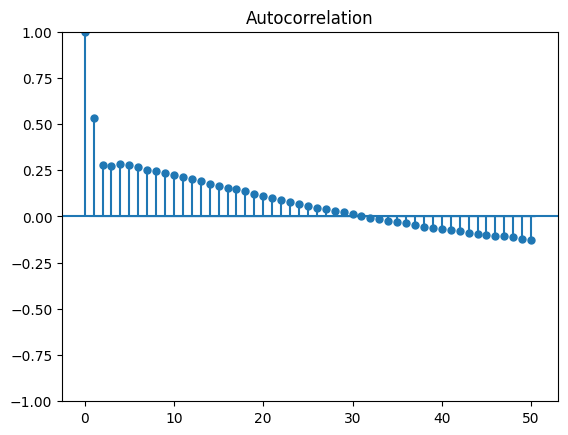

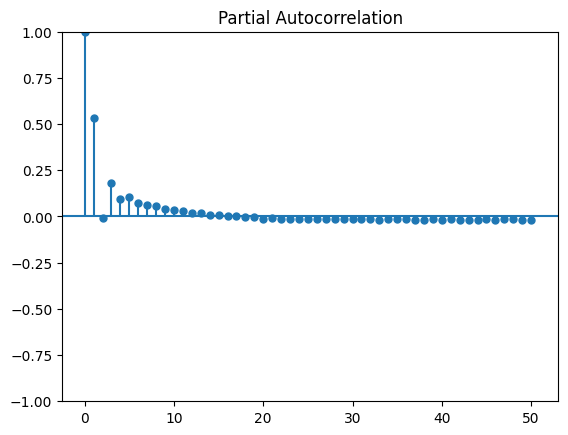

In [14]:
# Определение оптимальных параметров модели SARIMA
plot_acf(train_data['temperature'].diff().dropna(), lags=50);
plot_pacf(train_data['temperature'].diff().dropna(), lags=50);

In [15]:
# Оптимальные параметры модели SARIMA
order = (3, 1, 2)
seasonal_order = (1, 1, 1, 12)

# Обучение модели SARIMA на обучающей выборке
model = SARIMAX(train_data['temperature'].iloc[::1000], order=order, seasonal_order=seasonal_order, suppress_warning = True, error_action='ignore')

# model = pm.auto_arima(train_data['temperature'], seasonal=True, m=12, suppress_warnings=True, error_action = 'ignore')
model
results = model.fit()

# Прогнозирование на тестовой выборке
forecast = results.forecast(steps=len(test_data))


C:\Users\Сорокин\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Сорокин\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Сорокин\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['suppress_warning', 'error_action']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Users\Сорокин\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_ret

In [16]:
print (forecast.head(10))

337    15.304827
338    14.815057
339    12.977658
340    14.243200
341    12.357265
342    13.189877
343    13.987356
344    12.803049
345    13.630275
346    14.860445
Name: predicted_mean, dtype: float64


In [17]:
print (forecast.name)
print (test_data)

predicted_mean
        p (mbar)  temperature  temperature_potential  dew_point  rh (%)  \
336440    989.96        17.46                 291.46       9.52   59.58   
336441    989.87        17.36                 291.37       9.51   59.90   
336442    989.85        17.15                 291.16       9.52   60.76   
336443    989.86        16.92                 290.93       9.52   61.65   
336444    989.88        16.69                 290.69       9.60   62.89   
...          ...          ...                    ...        ...     ...   
420546   1000.07        -4.05                 269.10      -8.13   73.10   
420547    999.93        -3.35                 269.81      -8.06   69.71   
420548    999.82        -3.16                 270.01      -8.21   67.91   
420549    999.81        -4.23                 268.94      -8.53   71.80   
420550    999.82        -4.82                 268.36      -8.42   75.70   

        saturation_vapor_pressure_max  actual_vapor_pressure  \
336440              

In [18]:
# Вычисление MAE
mae = mean_absolute_error(test_data['temperature'], forecast)

print(f'MAE: {mae:.2f}')

MAE: 2558.63


In [19]:
# Загрузка данных
# data = pd.read_csv('https://github.com/zariable/data/raw/master/jena_climate_2009_2016.csv')
data = pd.read_csv("jena_climate_2009_2016.csv")
# print(Temperature.head())
# Преобразование столбца Date/Time в datetime формат
data['Date Time'] = pd.to_datetime(data['Date Time'], format='%d.%m.%Y %H:%M:%S')

In [20]:
# Ресемплирование данных по одному часу и вычисление среднего значения за каждый час
data = data.resample('H', on='Date Time').mean().dropna()

# Разделение данных на обучающую и тестовую выборки
train_data = data.iloc[:len(data)-365*24]
test_data = data.iloc[len(train_data):]


In [21]:
# Используем метод auto_arima() для подбора оптимальных параметров модели SARIMA
# model = pm.auto_arima(train_data['T (degC)'], seasonal=True, m=12, suppress_warnings=True)
# print(model.summary())



In [22]:
# Определение оптимальных параметров модели
order = model.order
seasonal_order = model.seasonal_order



In [23]:
# Обучение модели SARIMA на обучающей выборке
model = SARIMAX(train_data['T (degC)'], order=order, seasonal_order=seasonal_order)
results = model.fit()

# Прогнозирование на тестовой выборке
forecast = results.forecast(steps=len(test_data))



C:\Users\Сорокин\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Сорокин\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Сорокин\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Сорокин\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible s

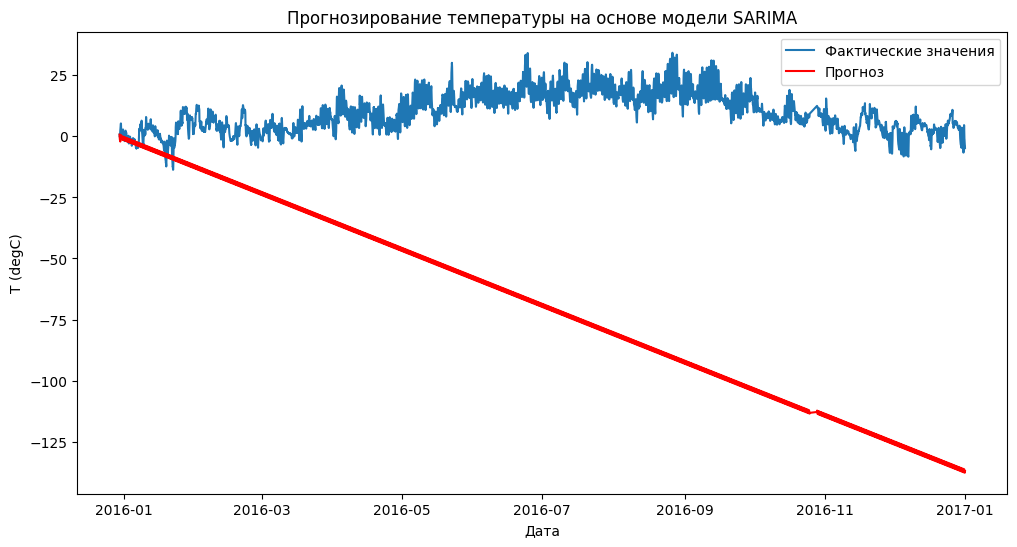

In [24]:
# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['T (degC)'], label='Фактические значения')
plt.plot(test_data.index, forecast, color='red', label='Прогноз')
plt.legend()
plt.title('Прогнозирование температуры на основе модели SARIMA')
plt.xlabel('Дата')
plt.ylabel('T (degC)')
plt.show()



In [25]:
# Оценка качества модели
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test_data['T (degC)'], forecast)
print('MAE:', round(mae, 2))

MAE: 78.63
